<a href="https://colab.research.google.com/github/selfproclaimedgenius1706/Alzheimer-s-Disease-Detection/blob/main/DeBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch

In [ ]:
%%capture
!python3 -m venv venv
!source venv/bin/activate
!pip install tensorflow transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import AutoTokenizer, TFDebertaForSequenceClassification
import pickle

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base", use_fast=False)

In [ ]:
df = pd.read_csv('dataToPadding.csv')
df = df[~df['Seri'].isin(['s004','s007','s024', 's096','s084','s085'])]

In [ ]:
def construct_encodings(data, tokenizer, max_len, truncation=True, padding=True):
    encodings = tokenizer(data, max_length=max_len, truncation=truncation, padding=padding)

    #Alert if any sample > max len
    for idx, input_ids in enumerate(encodings['input_ids']):
        if len(input_ids) > max_len:
            print(f"Warning: Sequence at index {idx} is longer than {max_len} tokens.")

    return encodings

In [ ]:
x = df['PreprocessedContent'].tolist()
y  = df['Label'].tolist()


#Tokenize
encodings = construct_encodings(x, tokenizer = tokenizer, max_len=40)

In [ ]:
for i in range(20):
  input_ids = encodings['input_ids'][i]
  attention_mask = encodings['attention_mask'][i]
  input_ids = tf.convert_to_tensor(input_ids)
  attention_mask = tf.convert_to_tensor(attention_mask)

  print("Input IDs:", input_ids)
  print("Attention Mask:", attention_mask)
  print("="*50)

Input IDs: tf.Tensor(
[    1  3056     5  1535    10   985  2934    89 37463 37463 14784     5
 10230 50118   463 37463     5  6410   490  1437  1437 50118   463   751
     5  2931     5  1535    10  1656    19    10  1437   740 26183  1656
 50118   463    47     2], shape=(40,), dtype=int32)
Attention Mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1], shape=(40,), dtype=int32)
Input IDs: tf.Tensor(
[    1 12465   428  1630  2459   562 15269    66  1116     5 20931 25413
  2934    15    10 50118   627  1690 22890  6908  4767    81  1437  1437
 50118   463     5  1972   584  1437  1437 50118  1193   298 33976   905
  4909  1798  1437     2], shape=(40,), dtype=int32)
Attention Mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1], shape=(40,), dtype=int32)
Input IDs: tf.Tensor(
[    1  1638   857  1437  1437  1437 50118   627  1535    10   410  2143
     8 36279   562  1437 36279  2934    15 

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, y)

In [ ]:
TEST_SPLIT = 0.3
train_size = int(len(x) * (1-TEST_SPLIT))

#Set batch size
BATCH_SIZE = 2

#shuffle lên
tfdataset = tfdataset.shuffle(len(x))

tfdataset_train = tfdataset.take(train_size)
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)

tfdataset_test = tfdataset.skip(train_size)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
import numpy as np


In [ ]:
N_EPOCHS = 10
model = TFDebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
optimizer = optimizers.Adam(learning_rate=1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier', 'cls_dropout', 'pooler']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 139193858 (530.98 MB)
Trainable params: 139193858 (530.98 MB)
Non-trainable para

In [ ]:


model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


36/36 [==============================] - 116s 2s/step - loss: 0.7075 - accuracy: 0.4583
Epoch 2/10
36/36 [==============================] - 57s 2s/step - loss: 0.6970 - accuracy: 0.4861
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6863 - accuracy: 0.5417
Epoch 4/10
36/36 [==============================] - 58s 2s/step - loss: 0.7033 - accuracy: 0.4861
Epoch 5/10
36/36 [==============================] - 61s 2s/step - loss: 0.7340 - accuracy: 0.4583
Epoch 6/10
36/36 [==============================] - 59s 2s/step - loss: 0.6596 - accuracy: 0.6250
Epoch 7/10
36/36 [==============================] - 58s 2s/step - loss: 0.6336 - accuracy: 0.6667
Epoch 8/10
36/36 [==============================] - 60s 2s/step - loss: 0.4251 - accuracy: 0.8194
Epoch 9/10
36/36 [==============================] - 59s 2s/step - loss: 0.3379 - accuracy: 0.8889
Epoch 10/10
36/36 [==============================] - 59s 2s/step - loss: 0.2492 - accuracy: 0.9306


In [ ]:
testDF = pd.read_csv('preprocessed_data2020.csv')
test_text = testDF['Preprocessed_Content']
test_label = testDF['label']

# Print the shape of the extracted arrays
print("test_text shape:", test_text.shape)
print("test_label shape:", test_label.shape)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 40,
    pad_to_max_length=True,
    truncation=True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

test_text shape: (48,)
test_label shape: (48,)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report

# Convert PyTorch tensors to TensorFlow tensors
test_seq_tf = tf.convert_to_tensor(test_seq.numpy())
test_mask_tf = tf.convert_to_tensor(test_mask.numpy())

# Use tf.config.list_physical_devices to check for GPU availability
gpu_available = tf.config.list_physical_devices('GPU')

# Use GPU if available, otherwise use CPU
device = "/GPU:0" if gpu_available else "/CPU:0"

with tf.device(device):
    preds = model([test_seq_tf, test_mask_tf])

# Access the logits and convert them to a NumPy array
logits = preds.logits.numpy()
preds = np.argmax(logits, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        24
           1       0.78      0.58      0.67        24

    accuracy                           0.71        48
   macro avg       0.72      0.71      0.70        48
weighted avg       0.72      0.71      0.70        48



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


model_directory = "/content/drive/MyDrive/DelBERTa"
model.save_pretrained(model_directory)

Mounted at /content/drive


In [ ]:
from sklearn.metrics import confusion_matrix
#Generate the confusion matrix
cf_matrix = confusion_matrix(test_label, preds)
print(cf_matrix)

[[20  4]
 [10 14]]


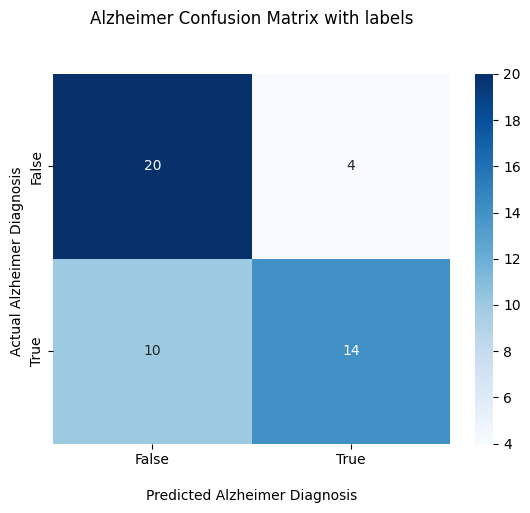

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Alzheimer Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Alzheimer Diagnosis')
ax.set_ylabel('Actual Alzheimer Diagnosis ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()